# Price Sensitivity simulation with Torch
## multi-arm contextual bandit

In [1]:
import jax
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.jit
import torch.distributions.normal as normal
import torch.distributions.uniform as uniform
import torch.distributions.beta as beta

# multi arm bandit base aglorithms 
from base_algos_torch import action_value_init, action_value_update, beta_init, beta_update, simulate_salesdata

In [2]:
# Random seed to make our experiment replicable 
SEED = 142

# Number of visitors we want to simulate
NUM_VISITS = 5000

PRICE_LIST = torch.arange(0, 1, 0.05)
FEATURE_SPACE = torch.tensor([[0, 1], [1, 0]], dtype=torch.float32)
PRICE_SENSITIVITY_PARMS = torch.tensor([[0.3,0.05], [0.5,0.1]], dtype=torch.float32)

In [3]:
def X_hist_init(n_feat):
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, n_feat + 1), dtype=torch.float32)

def y_hist_init():
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, 1), dtype=torch.float32)

def regret_hist_init():
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, 1), dtype=torch.float32)

def reward_hist_init():
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, 1), dtype=torch.float32)

In [4]:
def crossover_learning(X, sold, price, price_list):
    
    if sold:
        relevant_prices = price_list[price_list <= price]
    else:
        relevant_prices = price_list[price_list >= price]

    stacked_X = torch.stack([X] * len(relevant_prices), dim=0)
    X = torch.cat((stacked_X, relevant_prices.unsqueeze(1)), dim=1)
    y = sold.expand(len(relevant_prices),1)

    return X, y

In [5]:
def reward_fn(price):
    # turnover/profit genrated from sale
    return price

In [6]:
def visit(state, timestep, feature_list, price_list, price_sensitivity_params, policy_fn):
    """
    Simulates a user visit.
    """

    # Unpacking the experiment state
    params, beta_params, X_hist, y_hist, regret_hist, reward_hist = state
    torch.manual_seed(timestep)

    # simulate client type
    client_group = torch.randint(low=0, high=feature_list.shape[0], size=(1,))[0].item()

    # Selecting the variant to show the user, based on
    # the given policy, the agent's paramters, and the current timestep
    price = policy_fn(params, beta_params, feature_list[client_group], client_group, price_sensitivity_params[client_group], price_list, timestep)
    
    # Calculate Optimal Price
    exp_reward = (1 - normal.Normal(price_sensitivity_params[client_group][0], price_sensitivity_params[client_group][1]).cdf(price_list)) * reward_fn(price_list)
    optimal_price_index = torch.argmax(exp_reward)
    optimal_price = price_list[optimal_price_index]
    
    # regret
    regret = torch.abs(optimal_price - price)

    # Generate random normal number
    random_normal = torch.randn(1)  # Replace with the desired shape

    # Calculate client_price_limit
    client_price_limit = price_sensitivity_params[client_group][0] + price_sensitivity_params[client_group][1] * random_normal

    # Check if sold
    sold = client_price_limit >= price

    # reward
    reward = price*sold
    
    # perform cross-over learning observation simulation
    X_co, y_co = crossover_learning(feature_list[client_group], sold, price, price_list)

    # appending prices to feature space
    X_hist = torch.cat((X_hist, X_co), dim=0)
    y_hist = torch.cat((y_hist, y_co), dim=0)
    regret_hist = torch.cat((regret_hist, regret.view(1, 1)), dim=0)
    reward_hist = torch.cat((reward_hist, reward.view(1, 1)), dim=0)
    
    # Calculating the agent's updated parameters, based on
    # the current parameters, the price that was offered,
    # and whether or not the client accepted
    next_params = action_value_update(feature_list[client_group], price_list, client_group, params, price, sold)
    next_beta_params = beta_update(feature_list[client_group], price_list, client_group, beta_params, price, sold)
    
    # Returning the updated experiment state (rng) 
    return (next_params, next_beta_params, X_hist, y_hist, regret_hist, reward_hist)

## Implementing the policies

In [7]:
def epsilon_greedy_policy(params, beta_params, features, client_group, price_sensitivity_params, price_list, timestep, epsilon=0.1):
    """
    Randomly selects either the variant with highest action-value,
    or an arbitrary variant.
    """

    # Selecting a random variant
    def explore(params, client_group, price_list):
        i = torch.randint(len(price_list), (1,)).item()
        return price_list[i]

    # Selecting the variant with the highest action-value estimate
    def exploit(params, client_group, price_list):
        # maximum expected reward
        (n_dict, q_dict) = params
        exp_reward = q_dict[client_group] * price_list
        argmax = price_list[torch.argmax(exp_reward)]
        return argmax

    # Deciding randomly whether to explore or to exploit
    if torch.rand(1) < epsilon:
        return explore(params, client_group, price_list)
    else:
        return exploit(params, client_group, price_list)

In [8]:
def thompson_policy(params, beta_params, features, client_group, price_sensitivity_params, price_list, timestep):
    """
    Thompson sampling by drawing from conjugate prior beta distribution
    """

    a, b = beta_params
    dist = beta.Beta(a[client_group], b[client_group])
    sampled_price_index = torch.argmax(dist.sample() * reward_fn(price_list))
    price = price_list[sampled_price_index]

    return price

## Implementing the evaluation

In [9]:
from functools import partial
from matplotlib import pyplot as plt

In [10]:
def evaluate(policy_fn):
    """
    Simulating the experiment for NUM_VISITS users
    while accumulating the sales history
    """
    # Initial values
    init_state = (action_value_init(FEATURE_SPACE, PRICE_LIST), 
                  beta_init(FEATURE_SPACE, PRICE_LIST),
                  X_hist_init(len(FEATURE_SPACE)),
                  y_hist_init(),
                  regret_hist_init(),
                  reward_hist_init()
                 )
    
    state = init_state
    for timestep in range(1, NUM_VISITS + 1):
        state = visit(state, timestep, 
                      feature_list = FEATURE_SPACE, 
                      price_list = PRICE_LIST, 
                      price_sensitivity_params = PRICE_SENSITIVITY_PARMS, 
                      policy_fn = policy_fn)
    return state

In [11]:
# Epsilon greedy policy
(epsilon_greedy_params, epsilon_greedy_beta_params, epsilon_greedy_X_hist, epsilon_greedy_y_hist, epsilon_greedy_regret_hist, epsilon_greedy_reward_hist) = evaluate(
    policy_fn=partial(epsilon_greedy_policy, epsilon=0.1)
)

# Thompson sampling policy
(thompson_params, thompson_beta_params, thompson_X_hist, thompson_y_hist, thompson_regret_hist, thompson_reward_hist) = evaluate(
    policy_fn=partial(thompson_policy)
)

In [12]:
def cum_avg(tensor):
    cumulative_sum = tensor.cumsum(dim=0).squeeze()
    cumulative_average = cumulative_sum / torch.arange(1, cumulative_sum.size(0) + 1, dtype=torch.float32)
    return cumulative_average

cum_avg_regret_eg = cum_avg(epsilon_greedy_regret_hist)
cum_avg_regret_ts = cum_avg(thompson_regret_hist)
cum_avg_reward_eg = cum_avg(epsilon_greedy_reward_hist)
cum_avg_reward_ts = cum_avg(thompson_reward_hist)

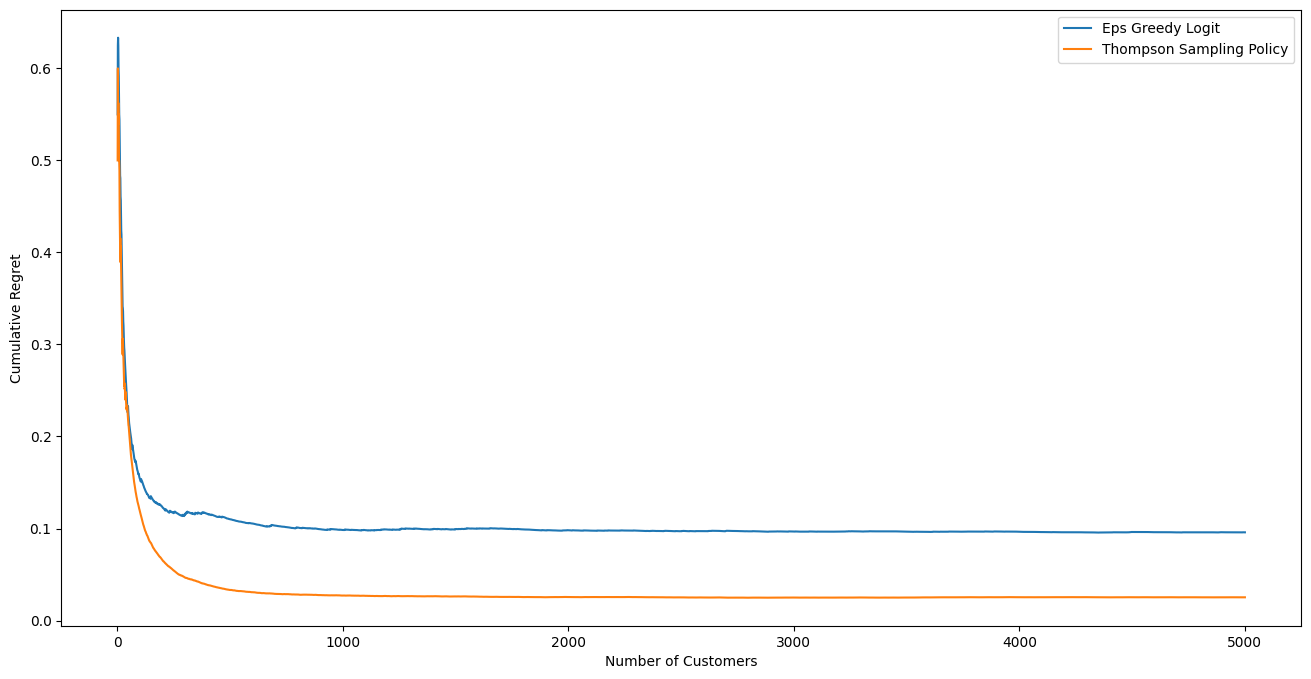

In [13]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = torch.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of Customers')
ax.set_ylabel('Cumulative Regret')

ax.plot(x, cum_avg_regret_eg, label='Eps Greedy Logit')
ax.plot(x, cum_avg_regret_ts, label='Thompson Sampling Policy')

plt.legend()
plt.show()

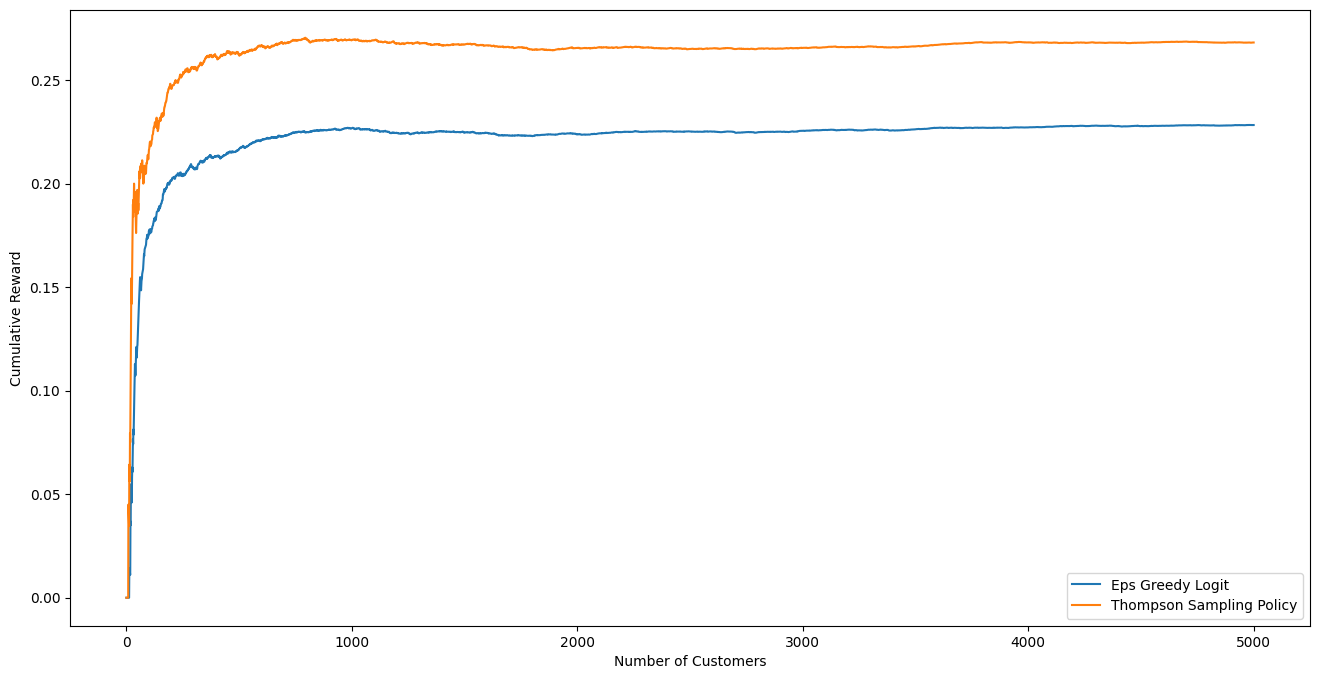

In [14]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = torch.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of Customers')
ax.set_ylabel('Cumulative Reward')

ax.plot(x, cum_avg_reward_eg, label='Eps Greedy Logit')
ax.plot(x, cum_avg_reward_ts, label='Thompson Sampling Policy')

plt.legend()
plt.show()